In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import pandas as pd
from sklearn import preprocessing
from torch.utils.data import DataLoader


from skew_correction.helper import *
from skew_correction.data import RegressionDataset, plot_random_images
from skew_correction.constants import device


ROOT_DIR = "/home/deepam_minda_farmart_co/fmt/skew_correction"

/opt/conda/envs/skew/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

train_csv_path = os.path.join(ROOT_DIR, 'data/rotated/train/data.csv')
train_df = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(ROOT_DIR, 'data/rotated/test/data.csv')
test_df = pd.read_csv(test_csv_path)

In [4]:
# scale angles
scaler = preprocessing.StandardScaler()
train_df['angle'] = scaler.fit_transform(train_df['angle'].values.reshape(-1, 1)) 
test_df['angle'] = scaler.transform(test_df['angle'].values.reshape(-1, 1))
# scaler.inverse_transform(train_df.angle[0].reshape(-1,1))

In [5]:
train_dataset = RegressionDataset(df = train_df)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)

test_dataset = RegressionDataset(df = test_df)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


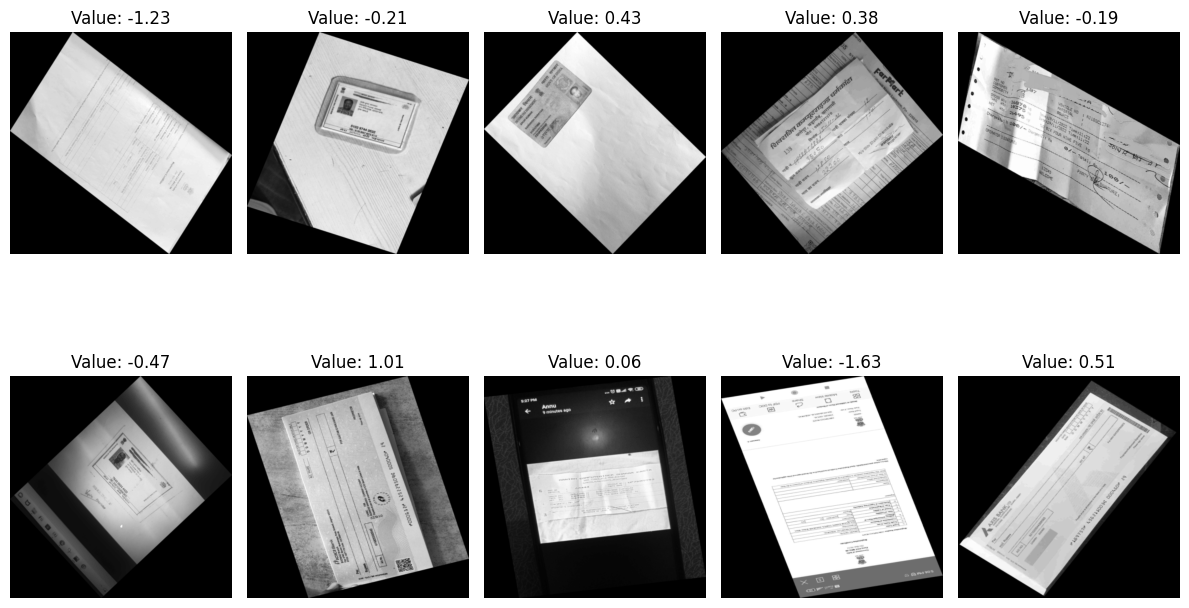

In [6]:
plot_random_images(train_dataset)

In [7]:
## define model class

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2048, 256, bias=True)
        self.linear2 = nn.Linear(256, 32)
        self.linear3 = nn.Linear(32, 1)
        

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x


In [33]:
## custom train code

epochs = 500
loss_fn = nn.L1Loss()
lr = 0.0005
batch_size = 8

# model = TimmRegressor("densenet121").to(device)
model = ConvNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# from torch.utils.data import Subset
# subset_indices = [1,2,3,4]
# subset_dataset = Subset(train_dataset, subset_indices)
# dummy_loader = DataLoader(subset_dataset, batch_size=4, shuffle=False, num_workers=2)

train_dataset = RegressionDataset(df = train_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = RegressionDataset(df = test_df)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

log_every = (len(train_dataloader)//batch_size)/4
log_every_test = (len(test_dataloader)//batch_size)/4



for epoch in tqdm(range(epochs)):
    print(f'==>Epoch {epoch+1}')
    model.train()
    running_loss = 0
    print('==>Train')
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        # print(f"input shape {x.size()}, output shape {y.size()}")
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        optimizer.zero_grad()
        # print(f"output {y_hat.detach().cpu()}, label {y.detach().cpu()}")
        
        loss = loss_fn(y_hat, y)
        running_loss += loss.item()
        
        if idx%log_every==0:
            print(f"output {np.array(y_hat.detach().cpu()).flatten()}, \nlabel {np.array(y.detach().cpu())}")
            print('train_loss', loss.item())

        loss.backward()
        optimizer.step()
    
    average_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - Average Loss: {average_loss:.4f}")
    # acc = get_acc(y_hat, y)
    # self.log('train_acc', acc, on_epoch=True, on_step=True)
    
    model.eval()
    with torch.no_grad():
        running_loss=0
        print('==>validation')
        for idx, batch in enumerate(test_dataloader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            # print(f"output {np.array(y_hat.detach().cpu()).flatten()}, \nlabel {np.array(y.detach().cpu())}")
            loss = loss_fn(y_hat, y)
            running_loss += loss.item()

            if idx%log_every_test==0:
                print(f"loss = {loss.item()}")
                print(f"output {np.array(y_hat.detach().cpu()).flatten()}, \nlabel {np.array(y.detach().cpu())}")
        average_loss = running_loss / len(test_dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Val Loss: {average_loss:.4f}")
            
        

  0%|          | 0/500 [00:00<?, ?it/s]

==>Epoch 1
==>Train


output [-0.26421937 -0.28259686 -0.42159182 -0.3116883  -0.34462655 -0.38011667
 -0.29487678 -0.3070057 ], 
label [-1.0451657   0.08723456  1.3357784   1.4616005   0.28080723  0.69698846
 -0.4160544   0.18402089]
train_loss 0.8515494465827942
output [-0.12240828 -0.08037259 -0.14768106 -0.12769997 -0.14638142 -0.11317955
 -0.09197106 -0.14561662], 
label [ 1.0550979  -0.1837672  -0.47412622  0.74538165 -1.4516683   0.74538165
 -0.99677247  1.529351  ]
train_loss 0.8976932764053345


In [31]:
# def evaluate()
model.eval()
with torch.no_grad():
     running_loss=0
     for idx, batch in enumerate(test_dataloader):
          x, y = batch
          x, y = x.to(device), y.to(device)
          y_hat = model(x)
          # print(f"output {np.array(y_hat.detach().cpu()).flatten()}, \nlabel {np.array(y.detach().cpu())}")
          loss = loss_fn(y_hat, y)
          running_loss += loss.item()

          if idx%log_every_test==0:
               print(f"loss = {loss.item()}")
               print(f"output {np.array(y_hat.detach().cpu()).flatten()}, \nlabel {np.array(y.detach().cpu())}")
     average_loss = running_loss / len(test_dataloader)
     print(f"Epoch [{epoch+1}/{epochs}] - Val Loss: {average_loss:.4f}")
           
          


loss = 0.9411894083023071
output [-0.10035795 -0.10112236 -0.10131031 -0.09920839 -0.09772325 -0.09872306
 -0.09272812 -0.09439167], 
label [ 1.2002774  -1.2484169   0.8131321   0.6195594   0.26144996  1.5583869
  0.5034158   0.73570305]
loss = 0.7646757960319519
output [-0.10012563 -0.10216291 -0.09637466 -0.10057224 -0.09992101 -0.09735247
 -0.09788987 -0.09925412], 
label [-0.57091254  0.7550603   0.9002398   0.3872722   1.6164587   0.22273543
  0.21305679 -1.0548443 ]
loss = 1.0241363048553467
output [-0.09960103 -0.10150982 -0.09941087 -0.09793358 -0.10299399 -0.10000629
 -0.09395238 -0.09671583], 
label [-1.5387759  -0.7354493   0.79377484 -1.3742392  -1.5678118  -1.0258083
  0.07755592  1.2777065 ]
loss = 0.810585618019104
output [-0.09915656 -0.09980721 -0.10067354 -0.09913935 -0.09803011 -0.0940824
 -0.09756264 -0.0933639 ], 
label [-0.42573303  0.30984312 -1.7517059   1.1905988   0.89056116 -0.34830397
 -1.5194187   0.04852002]
Epoch [1/500] - Val Loss: 0.8858


In [28]:
log_every = (len(train_dataloader)//batch_size)/4
log_every_test = len(test_dataloader)/4
log_every_test

6.0